In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels
import bumps

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas

In [179]:
true_reads = pd.read_csv('../../data/sans/Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Sphere')[0]

final_keys_spheres = true_reads[mask,0]

true_reads = pd.read_csv('../Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Ellipsoid')[0]

final_keys_ellipsoids = true_reads[mask,0]

true_reads = pd.read_csv('../Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Sphere+Cylinder')[0]

final_keys_sphere_cylinders = true_reads[mask,0]

true_reads = pd.read_csv('../Fit_Finals.csv')
true_reads = true_reads.to_numpy()
mask = np.where(true_reads[:,1]=='Ellipsoid+Cylinder')[0]

final_keys_ellipsoid_cylinders = true_reads[mask,0]

In [180]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
actual_vol = {}
actual_stdev_vol = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act
    actual_stdev[key] = stdev
    actual_vol[key] = act_vol
    actual_stdev_vol[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       'Polystyrene-D8':6.464, # density 1.13
       'Polystyrene-H8':1.426}


In [181]:
data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Loading polystyrene fit information.

In [182]:
background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [183]:
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])

In [184]:
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

In [185]:
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

In [186]:
avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])


Loading the Porod analysis results, we will only utilize the previously determined background values to minimize the fitting here.

In [187]:
porod_files = [file for file in os.listdir('../../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

Loading fit parameters from the results directory.

In [188]:
results_direct = '../data/sans/Sample_Fitting/fitting_results/ps_sphere/'
fit_keys = []
# fit_ps_porod_exp = {}
# fit_ps_rg = {}
# fit_ps_s = {}
# fit_ps_scale = {}
fit_sphere_radius= {}
fit_sphere_scale = {}

for file in [file for file in os.listdir(results_direct) if '.json' in file]:
    data_read = pd.read_json(results_direct + file)
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for pd_key, value in data_read.items():
#         if 'porod_exp' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_porod_exp[key] = (best, ci95)
#         elif 'rg' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_rg[key] = (best, ci95)
#         elif 'PS scale' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_scale[key] = (best, ci95)
#         elif 'PS s' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_s[key] = (best, ci95)
        if 'radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_sphere_radius[key] = (best, ci95)
        elif 'sphere scale' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_sphere_scale[key] = (best, ci95)
        


In [189]:
results_direct = '../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_match/'

fit_ellipsoid_polar_radius = {}
fit_ellipsoid_equatorial_radius = {}
fit_ellipsoid_scale = {}

for file in [file for file in os.listdir(results_direct) if '.json' in file]:
    data_read = pd.read_json(results_direct + file)
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for pd_key, value in data_read.items():
        if 'polar radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_polar_radius[key] = (best, ci95)
        elif 'equatorial radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_equatorial_radius[key] = (best, ci95)
        elif 'scale' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_scale[key] = (best, ci95)
        


In [193]:
results_direct = '../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder_lm/'

fit_sphcyl_sphere_radius = {}
fit_sphcyl_cylinder_radius = {}
fit_sphcyl_scale_ratio = {}
fit_sphcyl_cp_scale = {}
fit_sphcyl_cylinder_length = {}

for file in [file for file in os.listdir(results_direct) if '.csv' in file]:
    data_read = np.loadtxt(results_direct+file, delimiter=',', dtype='str')
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for label, x, dx in data_read:
        x = float(x)
        dx = float(dx)
        if 'radius' in label:
            if 'sphere' in label:
                fit_sphcyl_sphere_radius[key] = (x,dx)
            elif 'cylinder' in label:
                fit_sphcyl_cylinder_radius[key] = (x,dx)
        elif 'cp scale' in label:
            fit_sphcyl_cp_scale[key] = (x,dx)
        elif 'scale ratio' in label:
            fit_sphcyl_scale_ratio[key] = (x,dx)
        elif 'length' in label:
            fit_sphcyl_cylinder_length[key] = (x,dx)
            
    


In [194]:
results_direct = '../data/sans/Sample_Fitting/fitting_results/ps_ellipsoid_cylinder_lm/'

fit_ellcyl_polar_radius = {}
fit_ellcyl_equatorial_radius = {}
fit_ellcyl_cylinder_radius = {}
fit_ellcyl_scale_ratio = {}
fit_ellcyl_cp_scale = {}
fit_ellcyl_cylinder_length = {}

for file in [file for file in os.listdir(results_direct) if '.csv' in file]:
    data_read = np.loadtxt(results_direct+file, delimiter=',', dtype='str')
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for label, x, dx in data_read:
        x = float(x)
        dx = float(dx)
        if 'radius' in label:
            if 'cylinder' in label:
                fit_ellcyl_cylinder_radius[key] = (x,dx)
            elif 'polar' in label:
                fit_ellcyl_polar_radius[key] = (x,dx)
            elif 'equatorial' in label:
                fit_ellcyl_equatorial_radius[key] = (x,dx)
        elif 'cp scale' in label:
            fit_ellcyl_cp_scale[key] = (x,dx)
        elif 'scale ratio' in label:
            fit_ellcyl_scale_ratio[key] = (x,dx)
        elif 'length' in label:
            fit_ellcyl_cylinder_length[key] = (x,dx)
            
    


In [195]:
rre_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
rra_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
p3ddt_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
pqt_cf_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 

rre_tol_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
rre_bb_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
rre_cf_slow_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 

p3ddt_tol_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
p3ddt_bb_spheres = [key for key in final_keys_spheres if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']


rre_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
rra_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
p3ddt_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
pqt_cf_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 

rre_tol_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
rre_bb_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
rre_cf_slow_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 

p3ddt_tol_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
p3ddt_bb_ellipsoids = [key for key in final_keys_ellipsoids if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']



rre_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
rra_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
p3ddt_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
pqt_cf_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 

rre_tol_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
rre_bb_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
rre_cf_slow_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 

p3ddt_tol_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
p3ddt_bb_sphcyl = [key for key in final_keys_sphere_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']


rre_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRe-P3HT'] 
rra_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'RRa-P3HT'] 
p3ddt_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'P3DDT'] 
pqt_cf_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Chloroform' and cps[key] == 'PQT-12'] 

rre_tol_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'RRe-P3HT'] 
rre_bb_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'RRe-P3HT']
rre_cf_slow_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Slow Dry Chloroform' and cps[key] == 'RRe-P3HT'] 

p3ddt_tol_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Toluene' and cps[key] == 'P3DDT'] 
p3ddt_bb_ellcyl = [key for key in final_keys_ellipsoid_cylinders if solvent_names[key] == 'Bromobenzene' and cps[key] == 'P3DDT']


In [196]:
def rg_sphere(r):
    
    " returns the radius of gyration for an ellipsoid of rotation "

    rg_sphere = np.sqrt((3/5)*r**2)
    
    return(rg_sphere)
    

def rg_ellipsoid(polar, equatorial):
    
    " returns the radius of gyration for an ellipsoid of rotation "

    rg_ellip = np.sqrt((1/5)*(polar**2 + 2*equatorial**2))
    
    return(rg_ellip)
    

In [345]:
def plot_rg(sphere_keys, ellipsoid_keys, sphcyl_keys, ellcyl_keys, sphere_label, color):
    
    '''
    Plotting sphere fits
    '''
    
    wtP = []
    radius_list = []
    error_list = []
    
    for key in sphere_keys:
        wtP.append(actual[key])
        r_sphere = fit_sphere_radius[key][0]
        r_sphere_low = fit_sphere_radius[key][1][0]
        r_sphere_high = fit_sphere_radius[key][1][1]
        
        r_sphere = rg_sphere(r_sphere)
        r_sphere_low = rg_sphere(r_sphere_low)
        r_sphere_high = rg_sphere(r_sphere_high)
        
        radius_list.append(r_sphere)
        error_list.append(np.absolute(r_sphere - r_sphere_low))
        error_list.append(np.absolute(r_sphere - r_sphere_high))
        
    error_list = np.array(error_list).reshape(-1,2).T
        
    plt.errorbar(wtP, radius_list, label=sphere_label, color=color, fmt='o', ms=8)
    
    
    '''
    Plotting ellipsoid fits
    '''
    
    wtP = []
    radius_list = []
    error_list = []
        
    for key in ellipsoid_keys:
        wtP.append(actual[key])
        
        radius_polar = fit_ellipsoid_polar_radius[key][0]
        radius_polar_low = fit_ellipsoid_polar_radius[key][1][0]
        radius_polar_high = fit_ellipsoid_polar_radius[key][1][1]
        
        radius_equatorial = fit_ellipsoid_equatorial_radius[key][0]
        radius_equatorial_low = fit_ellipsoid_polar_radius[key][1][0]
        radius_equatorial_high = fit_ellipsoid_polar_radius[key][1][1]
        
        r_ellipsoid = rg_ellipsoid(radius_polar, radius_equatorial)
        r_ellipsoid_low = rg_ellipsoid(radius_polar_low, radius_equatorial_low)
        r_ellipsoid_high = rg_ellipsoid(radius_polar_high, radius_equatorial_high)
        
        radius_list.append(r_ellipsoid)
        error_list.append(np.absolute(r_ellipsoid - r_ellipsoid_low))
        error_list.append(np.absolute(r_ellipsoid - r_ellipsoid_high))
        
    error_list = np.array(error_list).reshape(-1,2).T
        
    plt.errorbar(wtP, radius_list, color=color, fmt='^', ms=8)

    
    '''
    Plotting sphere+cylinder fits
    '''
    
    wtP = []
    radius_list = []
    error_list = []
    
    for key in sphcyl_keys:
        wtP.append(actual[key])
        r_sphere = fit_sphcyl_sphere_radius[key][0]
        #r_sphere_low = fit_sphere_radius[key][1][0]
        #r_sphere_high = fit_sphere_radius[key][1][1]
        
        r_sphere = rg_sphere(r_sphere)
        #r_sphere_low = rg_sphere(r_sphere_low)
        #r_sphere_high = rg_sphere(r_sphere_high)
        
        radius_list.append(r_sphere)
        #error_list.append(np.absolute(r_sphere - r_sphere_low))
        #error_list.append(np.absolute(r_sphere - r_sphere_high))
        
    #error_list = np.array(error_list).reshape(-1,2).T
        
    plt.errorbar(wtP, radius_list, color=color, fmt='s', ms=8)
    
    
    '''
    Plotting ellipsoid fits
    '''
    
    wtP = []
    radius_list = []
    error_list = []
        
    for key in ellcyl_keys:
        wtP.append(actual[key])
        
        radius_polar = fit_ellcyl_polar_radius[key][0]
        #radius_polar_low = fit_ellipsoid_polar_radius[key][1][0]
        #radius_polar_high = fit_ellipsoid_polar_radius[key][1][1]
        
        radius_equatorial = fit_ellcyl_equatorial_radius[key][0]
        #radius_equatorial_low = fit_ellipsoid_polar_radius[key][1][0]
        #radius_equatorial_high = fit_ellipsoid_polar_radius[key][1][1]
        
        r_ellipsoid = rg_ellipsoid(radius_polar, radius_equatorial)
        #r_ellipsoid_low = rg_ellipsoid(radius_polar_low, radius_equatorial_low)
        #r_ellipsoid_high = rg_ellipsoid(radius_polar_high, radius_equatorial_high)
        
        radius_list.append(r_ellipsoid)
        #error_list.append(np.absolute(r_ellipsoid - r_ellipsoid_low))
        #error_list.append(np.absolute(r_ellipsoid - r_ellipsoid_high))
        
    #error_list = np.array(error_list).reshape(-1,2).T
        
    plt.errorbar(wtP, radius_list, color=color, fmt='D', ms=8)


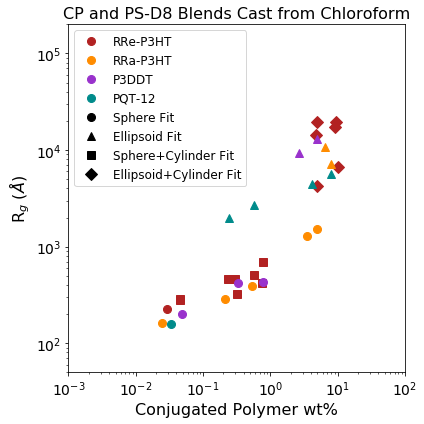

In [346]:
../data/sans/Sample_Fitting/plt.figure(figsize=(6,6))

plot_rg(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick')
plot_rg(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange')
plot_rg(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid')
plot_rg(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan')

plt.xscale('log')
plt.xlim(0.001,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=16)
plt.xticks(fontsize=14)

plt.ylabel(r'R$_g$ ($\AA$)', fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(5e1,2e5)
plt.yscale('log')

plt.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)

plt.title('CP and PS-D8 Blends Cast from Chloroform',fontsize=16)

plt.legend(fontsize=12,loc='upper left')# ncol=3)

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/radius_plots/RRaP3HT_P3DDT_PQT12_CF_radius.png', dpi=300)

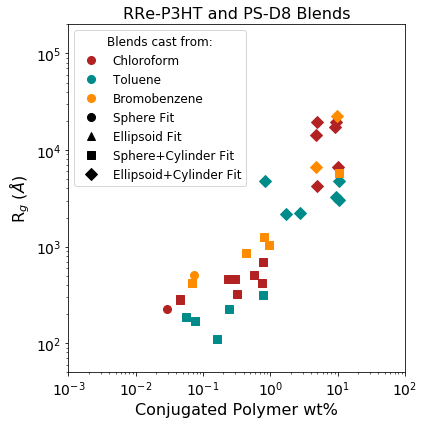

In [347]:
plt.figure(figsize=(6,6))

plot_rg(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick')
plot_rg(rre_tol_spheres, rre_tol_ellipsoids, rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene',  'darkcyan')
plot_rg(rre_bb_spheres, rre_bb_ellipsoids, rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene',  'darkorange')


plt.xscale('log')
plt.xlim(0.001,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=16)
plt.xticks(fontsize=14)

plt.ylabel(r'R$_g$ ($\AA$)', fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(5e1,2e5)
plt.yscale('log')

plt.title('RRe-P3HT and PS-D8 Blends',fontsize=16)

plt.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)

plt.legend(fontsize=12,loc='upper left',title='Blends cast from:', title_fontsize=12)# ncol=3)

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/radius_plots/RReP3HT_all_radius.png', dpi=300)

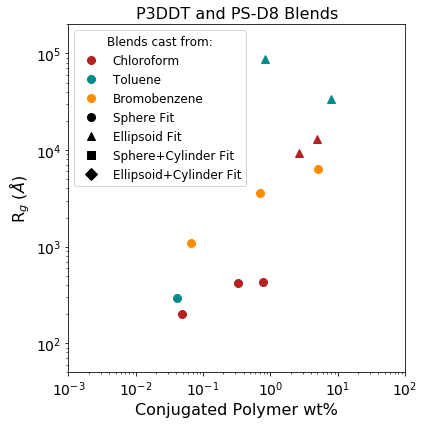

In [348]:
plt.figure(figsize=(6,6))

plot_rg(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'Chloroform', 'firebrick')
plot_rg(p3ddt_tol_spheres, p3ddt_tol_ellipsoids, p3ddt_tol_sphcyl, p3ddt_tol_ellcyl, 'Toluene', 'darkcyan')
plot_rg(p3ddt_bb_spheres, p3ddt_bb_ellipsoids, p3ddt_bb_sphcyl, p3ddt_bb_ellcyl, 'Bromobenzene', 'darkorange')


plt.xscale('log')
plt.xlim(0.001,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=16)
plt.xticks(fontsize=14)

plt.ylabel(r'R$_g$ ($\AA$)', fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(5e1,2e5)
plt.yscale('log')

plt.errorbar([0],[0],fmt='o',label='Sphere Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='^',label='Ellipsoid Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='s',label='Sphere+Cylinder Fit', color='black',ms=8)
plt.errorbar([0],[0],fmt='D',label='Ellipsoid+Cylinder Fit', color='black',ms=8)

plt.title('P3DDT and PS-D8 Blends',fontsize=16)

plt.legend(fontsize=12,loc='upper left',title='Blends cast from:', title_fontsize=12)# ncol=3)

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/radius_plots/P3DDT_Tol_BB_CF_radius.png', dpi=300)



In [201]:
def plot_scale(sphere_list, ellipsoid_list, sphcyl_list, ellcyl_list, label, color):
    
    # sphere
    wtP = []
    radius_list = []
    #radius_error = []

    for key in sphere_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_sphere_scale[key][0]*100)
        #radius_error.append(fit_sphere_scale[key][1][0]*100)
        #radius_error.append(fit_sphere_scale[key][1][1]*100)
     
    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    #plt.errorbar(wtP, radius_list, yerr=radius_error_corr, capsize=7, c=color, label=label, fmt='o', ms=7, zorder=1)
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=label, fmt='o', ms=7, zorder=1)
    
    # ellipsoid
    wtP = []
    radius_list = []
    #radius_error = []

    for key in ellipsoid_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_ellipsoid_scale[key][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][1]*100)

    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    #plt.errorbar(wtP, radius_list, yerr=radius_error_corr, capsize=7, c=color, label=None, fmt='^', ms=7, zorder=1)
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='^', ms=7, zorder=1)

    # sphere+cylinder
    wtP = []
    radius_list = []
    #radius_error = []

    for key in sphcyl_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_sphcyl_cp_scale[key][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][1]*100)

    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='s', ms=7, zorder=1)

    
    # ellipsoid+cylinder
    wtP = []
    radius_list = []
    #radius_error = []

    for key in ellcyl_list:
        wtP.append(actual_vol[key])
        radius_list.append(fit_ellcyl_cp_scale[key][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][0]*100)
        #radius_error.append(fit_ellipsoid_scale[key][1][1]*100)

    #radius_error = np.array(radius_error).reshape(-1,2).T
    radius_list = np.array(radius_list)
    #radius_error_corr = np.absolute(radius_error - radius_list)
    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='D', ms=7, zorder=1)



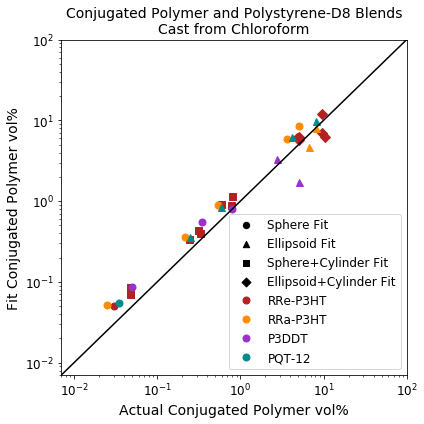

In [202]:
plt.figure(figsize=(6,6))


plot_scale(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick')
plot_scale(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange')
plot_scale(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid')
plot_scale(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan')

plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Actual Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/CF_scales.png', dpi=300)

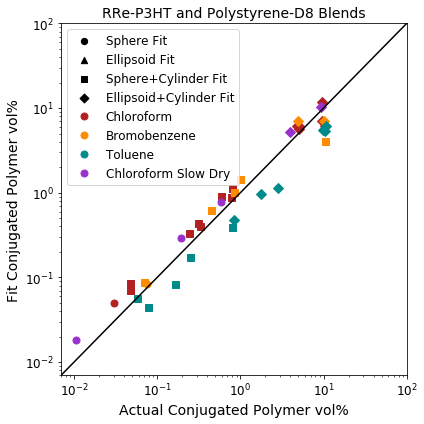

In [203]:
plt.figure(figsize=(6,6))


plot_scale(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick')
plot_scale(rre_bb_spheres, rre_bb_ellipsoids, rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange')
plot_scale(rre_tol_spheres, rre_tol_ellipsoids, rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan')
plot_scale(rre_cf_slow_spheres, rre_cf_slow_ellipsoids, rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid')


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Actual Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/RReP3HT_scales.png', dpi=300)

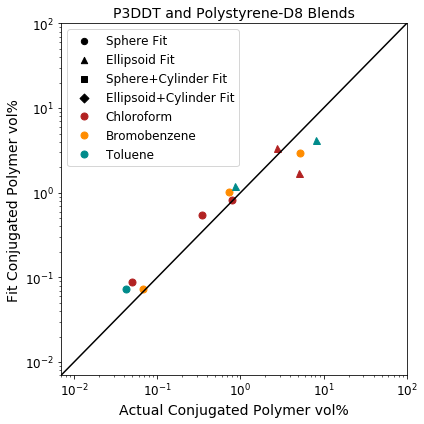

In [204]:
plt.figure(figsize=(6,6))


plot_scale(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'Chloroform', 'firebrick')
plot_scale(p3ddt_bb_spheres, p3ddt_bb_ellipsoids, p3ddt_bb_sphcyl, p3ddt_bb_ellcyl, 'Bromobenzene', 'darkorange')
plot_scale(p3ddt_tol_spheres, p3ddt_tol_ellipsoids, p3ddt_tol_sphcyl, p3ddt_tol_ellcyl, 'Toluene', 'darkcyan')


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Actual Conjugated Polymer vol%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Conjugated Polymer vol%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('P3DDT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/P3DDT_scales.png', dpi=300)

### Nanofiber Concentration

In [340]:
def plot_nf_concentration(sphcyl_list, ellcyl_list, label, color, fit_scale=False):
    
    
    def vol2wtP(v_cp):
        den_cp = 1.1
        den_ps = 1.13
        
        m_cp = v_cp*den_cp
        m_ps = (1-v_cp)*den_ps
        
        x_cp = m_cp/(m_cp+m_ps)
        return(x_cp)
    
    # sphere+cylinder
    wtP = []
    radius_list = []

    for key in sphcyl_list:
        if fit_scale is True:
            wtP.append(vol2wtP(fit_sphcyl_cp_scale[key][0])*100)
            radius_list.append(vol2wtP(fit_sphcyl_cp_scale[key][0])*100*(1-fit_sphcyl_scale_ratio[key][0]))
        else:
            wtP.append(actual[key])
            radius_list.append(actual[key]*(1-fit_sphcyl_scale_ratio[key][0]))
        
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=label, fmt='s', ms=7, zorder=1)

    
    # ellipsoid+cylinder
    wtP = []
    radius_list = []

    for key in ellcyl_list:
        if fit_scale is True:
            wtP.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100)
            radius_list.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100*(1-fit_ellcyl_scale_ratio[key][0]))
        else:
            wtP.append(actual[key])
            radius_list.append(actual[key]*(1-fit_ellcyl_scale_ratio[key][0]))
       
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='D', ms=7, zorder=1)



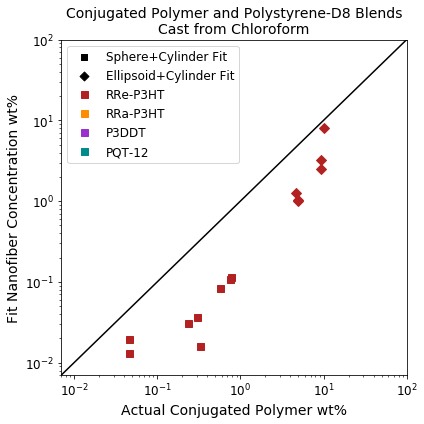

In [341]:
plt.figure(figsize=(6,6))


plot_nf_concentration(rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', fit_scale=False)
plot_nf_concentration(rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', fit_scale=False)
plot_nf_concentration(p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', fit_scale=False)
plot_nf_concentration(pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', fit_scale=False)

plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Actual Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Nanofiber Concentration wt%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/CF_NFconc_UVVisScales.png', dpi=300)

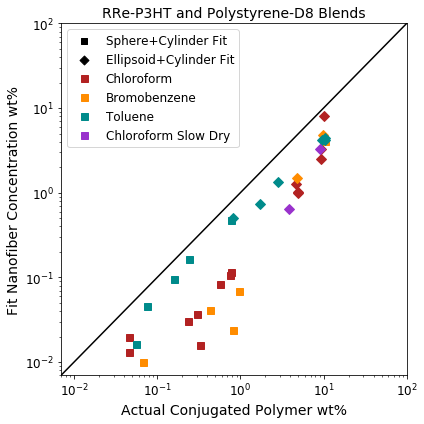

In [342]:
plt.figure(figsize=(6,6))


plot_nf_concentration(rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick', fit_scale=False)
plot_nf_concentration(rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange', fit_scale=False)
plot_nf_concentration(rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan', fit_scale=False)
plot_nf_concentration(rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid', fit_scale=False)


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Actual Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Nanofiber Concentration wt%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/RReP3HT_NFconc_UVVisScales.png', dpi=300)

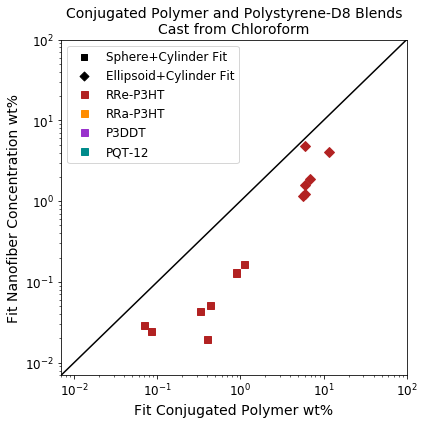

In [343]:
plt.figure(figsize=(6,6))


plot_nf_concentration(rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', fit_scale=True)
plot_nf_concentration(rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', fit_scale=True)
plot_nf_concentration(p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', fit_scale=True)
plot_nf_concentration(pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', fit_scale=True)

plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Fit Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Nanofiber Concentration wt%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/CF_NFconc_FitScales.png', dpi=300)

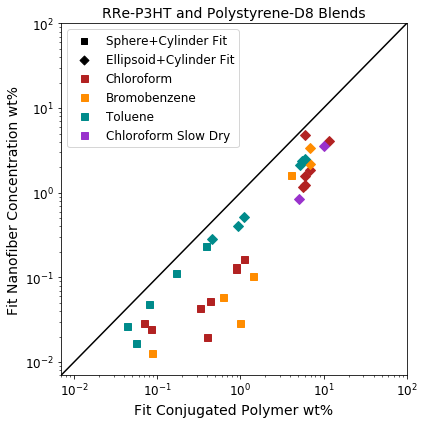

In [344]:
plt.figure(figsize=(6,6))


plot_nf_concentration(rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick', fit_scale=True)
plot_nf_concentration(rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange', fit_scale=True)
plot_nf_concentration(rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan', fit_scale=True)
plot_nf_concentration(rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid', fit_scale=True)


plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Fit Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel('Fit Nanofiber Concentration wt%', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0.007,100)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/RReP3HT_NFconc_FitScales.png', dpi=300)

In [349]:
def plot_nf_fraction(sphere_list, ellipsoid_list, sphcyl_list, ellcyl_list, label, color, fit_scale=False):
    
    
    def vol2wtP(v_cp):
        den_cp = 1.1
        den_ps = 1.13
        
        m_cp = v_cp*den_cp
        m_ps = (1-v_cp)*den_ps
        
        x_cp = m_cp/(m_cp+m_ps)
        return(x_cp)
    
    # sphere
    
    wtP = []
    radius_list = []
    for key in sphere_list:
        if fit_scale is True:
            wtP.append(vol2wtP(fit_sphere_scale[key][0])*100)
        else:
            wtP.append(actual[key])
        radius_list.append(0)
        
    plt.errorbar(wtP, radius_list, capsize=7, c=color, fmt='o', ms=7, zorder=1)
        
    # ellipsoid
    
    wtP = []
    radius_list = []
    for key in ellipsoid_list:
        if fit_scale is True:
            wtP.append(vol2wtP(fit_ellipsoid_scale[key][0])*100)
        else:
            wtP.append(actual[key])
        radius_list.append(0)
        
    plt.errorbar(wtP, radius_list, capsize=7, c=color, fmt='^', ms=7, zorder=1)
    
    
    # sphere+cylinder
    wtP = []
    radius_list = []

    for key in sphcyl_list:
#         if actual[key] < 0.2:
#             print(key)
        if fit_scale is True:
            wtP.append(vol2wtP(fit_sphcyl_cp_scale[key][0])*100)
            radius_list.append(100*(1-fit_sphcyl_scale_ratio[key][0]))
        else:
            wtP.append(actual[key])
            radius_list.append(100*(1-fit_sphcyl_scale_ratio[key][0]))
        
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=label, fmt='s', ms=7, zorder=1)

    
    # ellipsoid+cylinder
    wtP = []
    radius_list = []

    for key in ellcyl_list:
#         if actual[key] < 0.2:
#             print(key)
        if fit_scale is True:
            wtP.append(vol2wtP(fit_ellcyl_cp_scale[key][0])*100)
            radius_list.append(100*(1-fit_ellcyl_scale_ratio[key][0]))
        else:
            wtP.append(actual[key])
            radius_list.append(100*(1-fit_ellcyl_scale_ratio[key][0]))
       
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='D', ms=7, zorder=1)



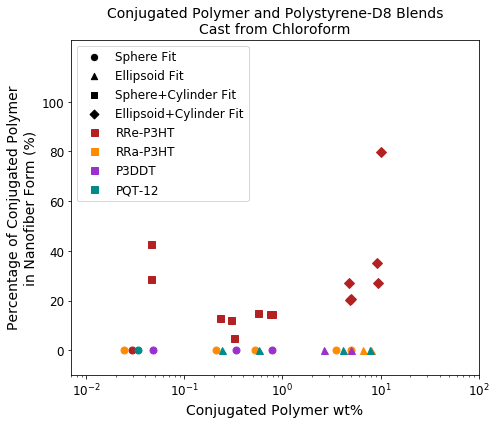

In [350]:
plt.figure(figsize=(7,6))


plot_nf_fraction(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', fit_scale=False)
plot_nf_fraction(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', fit_scale=False)
plot_nf_fraction(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', fit_scale=False)
plot_nf_fraction(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', fit_scale=False)

#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

#plt.yscale('log')
plt.ylabel('Percentage of Conjugated Polymer\nin Nanofiber Form (%)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(-10,125)
plt.yticks(np.arange(0,120,20))

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/CF_NFpercent_UVVisScales.png', dpi=300)

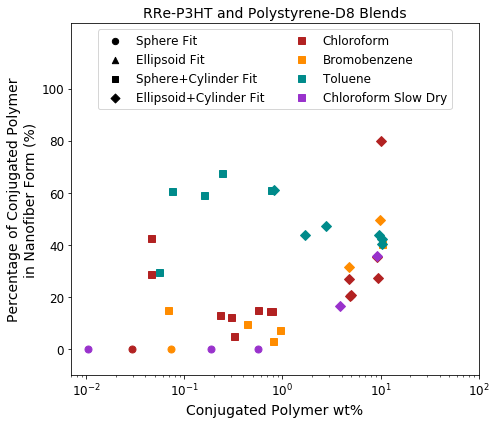

In [351]:
plt.figure(figsize=(7,6))


plot_nf_fraction(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick', fit_scale=False)
plot_nf_fraction(rre_bb_spheres, rre_bb_ellipsoids, rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange', fit_scale=False)
plot_nf_fraction(rre_tol_spheres, rre_tol_ellipsoids, rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan', fit_scale=False)
plot_nf_fraction(rre_cf_slow_spheres, rre_cf_slow_ellipsoids, rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid', fit_scale=False)


#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

#plt.yscale('log')
plt.ylabel('Percentage of Conjugated Polymer\nin Nanofiber Form (%)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(-10,125)
plt.yticks(np.arange(0,120,20))

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper center',ncol=2)

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/RReP3HT_NFpercent_UVVisScales.png', dpi=300)

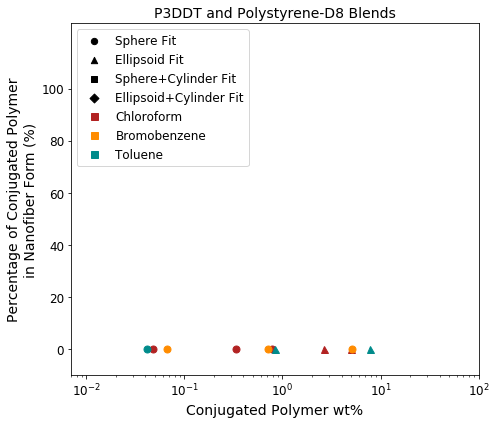

In [352]:
plt.figure(figsize=(7,6))


plot_nf_fraction(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'Chloroform', 'firebrick',fit_scale=False)
plot_nf_fraction(p3ddt_bb_spheres, p3ddt_bb_ellipsoids, p3ddt_bb_sphcyl, p3ddt_bb_ellcyl, 'Bromobenzene', 'darkorange',fit_scale=False)
plot_nf_fraction(p3ddt_tol_spheres, p3ddt_tol_ellipsoids, p3ddt_tol_sphcyl, p3ddt_tol_ellcyl, 'Toluene', 'darkcyan',fit_scale=False)


#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

#plt.yscale('log')
plt.ylabel('Percentage of Conjugated Polymer\nin Nanofiber Form (%)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(-10,125)
plt.yticks(np.arange(0,120,20))

plt.title('P3DDT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/P3DDT_NFpercent_UVVisScales.png', dpi=300)

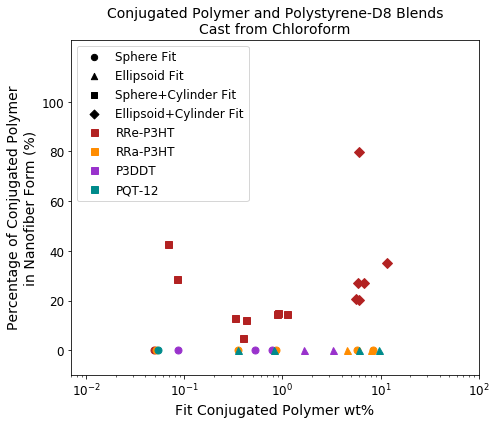

In [336]:
plt.figure(figsize=(7,6))


plot_nf_fraction(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick', fit_scale=True)
plot_nf_fraction(rra_cf_spheres, rra_cf_ellipsoids, rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange', fit_scale=True)
plot_nf_fraction(p3ddt_cf_spheres, p3ddt_cf_ellipsoids, p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid', fit_scale=True)
plot_nf_fraction(pqt_cf_spheres, pqt_cf_ellipsoids, pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan', fit_scale=True)

#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Fit Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

#plt.yscale('log')
plt.ylabel('Percentage of Conjugated Polymer\nin Nanofiber Form (%)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(-10,125)
plt.yticks(np.arange(0,120,20))
plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/CF_NFpercent_FitScales.png', dpi=300)

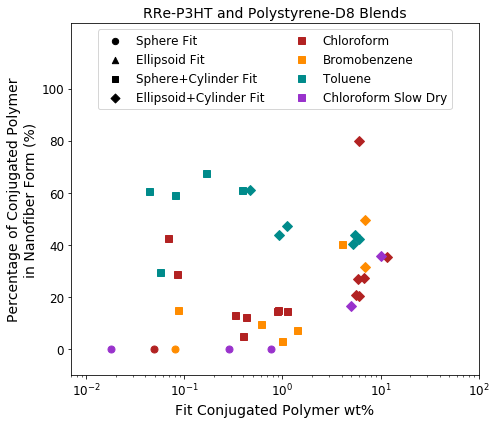

In [337]:
plt.figure(figsize=(7,6))


plot_nf_fraction(rre_cf_spheres, rre_cf_ellipsoids, rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick', fit_scale=True)
plot_nf_fraction(rre_bb_spheres, rre_bb_ellipsoids, rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange', fit_scale=True)
plot_nf_fraction(rre_tol_spheres, rre_tol_ellipsoids, rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan', fit_scale=True)
plot_nf_fraction(rre_cf_slow_spheres, rre_cf_slow_ellipsoids, rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid', fit_scale=True)


#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='o', s=40, label='Sphere Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='^', s=40, label='Ellipsoid Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Fit Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

#plt.yscale('log')
plt.ylabel('Percentage of Conjugated Polymer\nin Nanofiber Form (%)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(-10,125)
plt.yticks(np.arange(0,120,20))
plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper center',ncol=2)

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/RReP3HT_NFpercent_FitScales.png', dpi=300)

### Plotting Nanofiber Size

In [292]:
def plot_nf_rad(sphcyl_list, ellcyl_list, label, color):
    
    
    def vol2wtP(v_cp):
        den_cp = 1.1
        den_ps = 1.13
        
        m_cp = v_cp*den_cp
        m_ps = (1-v_cp)*den_ps
        
        x_cp = m_cp/(m_cp+m_ps)
        return(x_cp)
    
    # sphere+cylinder
    wtP = []
    radius_list = []

    for key in sphcyl_list:
        wtP.append(actual[key])
        radius_list.append(fit_sphcyl_cylinder_radius[key][0])
          
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=label, fmt='s', ms=7, zorder=1)

    
    # ellipsoid+cylinder
    wtP = []
    radius_list = []

    for key in ellcyl_list:
        wtP.append(actual[key])
        radius_list.append(fit_ellcyl_cylinder_radius[key][0])
    radius_list = np.array(radius_list)    
    plt.errorbar(wtP, radius_list, capsize=7, c=color, label=None, fmt='D', ms=7, zorder=1)
    
  

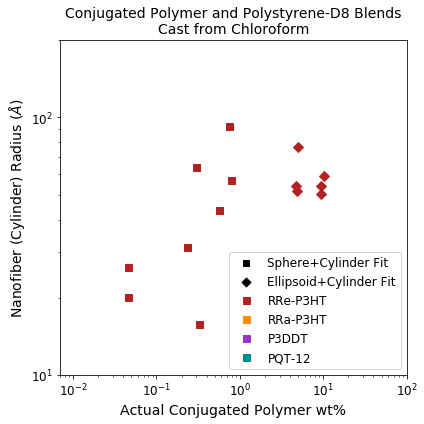

In [302]:
plt.figure(figsize=(6,6))


plot_nf_rad(rre_cf_sphcyl, rre_cf_ellcyl, 'RRe-P3HT', 'firebrick')
plot_nf_rad(rra_cf_sphcyl, rra_cf_ellcyl, 'RRa-P3HT', 'darkorange')
plot_nf_rad(p3ddt_cf_sphcyl, p3ddt_cf_ellcyl, 'P3DDT', 'darkorchid')
plot_nf_rad(pqt_cf_sphcyl, pqt_cf_ellcyl, 'PQT-12', 'darkcyan')

#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Actual Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

plt.yscale('log')
plt.ylabel(r'Nanofiber (Cylinder) Radius ($\AA$)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(10,200)

plt.title('Conjugated Polymer and Polystyrene-D8 Blends\nCast from Chloroform',fontsize=14)

plt.legend(fontsize=12,loc='lower right')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/CF_NFRad.png', dpi=300)

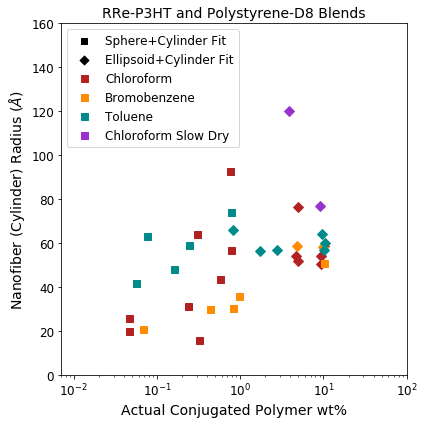

In [354]:
plt.figure(figsize=(6,6))


plot_nf_rad(rre_cf_sphcyl, rre_cf_ellcyl, 'Chloroform', 'firebrick')
plot_nf_rad(rre_bb_sphcyl, rre_bb_ellcyl, 'Bromobenzene', 'darkorange')
plot_nf_rad(rre_tol_sphcyl, rre_tol_ellcyl, 'Toluene', 'darkcyan')
plot_nf_rad(rre_cf_slow_sphcyl, rre_cf_slow_ellcyl, 'Chloroform Slow Dry', 'darkorchid')


#plt.plot([1e-3,1e5],[1e-3,1e5],color='black')
plt.scatter([1e-3],[1e-3],color='black', marker='s', s=40, label='Sphere+Cylinder Fit')
plt.scatter([1e-3],[1e-3],color='black', marker='D', s=40, label='Ellipsoid+Cylinder Fit')

plt.xscale('log')
plt.xlim(0.007,100)
plt.xlabel('Actual Conjugated Polymer wt%', fontsize=14)
plt.xticks(fontsize=12)

#plt.yscale('log')
plt.ylabel(r'Nanofiber (Cylinder) Radius ($\AA$)', fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0,160)

plt.title('RRe-P3HT and Polystyrene-D8 Blends',fontsize=14)

plt.legend(fontsize=12,loc='upper left')

plt.tight_layout()
plt.savefig('../data/sans/Sample_Fitting/fitting_figures/scale_plots/RReP3HT_NFRad.png', dpi=300)